# Overview
Kyrylo Rudavskyy  
500867152

References:  
[1]M.-I. Nicolae et al., “Adversarial Robustness Toolbox v1.0.0,” arXiv:1807.01069 [cs, stat], Nov. 2019, Accessed: Dec. 13, 2020. [Online]. Available: http://arxiv.org/abs/1807.01069.

[2]I. Gulrajani, F. Ahmed, M. Arjovsky, V. Dumoulin, and A. Courville, “Improved Training of Wasserstein GANs,” arXiv:1704.00028 [cs, stat], Dec. 2017, Accessed: Dec. 13, 2020. [Online]. Available: http://arxiv.org
/abs/1704.00028.

[3]R. Kohavi, “Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid,” p. 6, 1996.

[4]D. Dua and C. Graff, “UCI machine learning repository,” 2017, [Online]. Available: http://archive.ics.uci.edu/ml.  

[5]J. Snoke, G. Raab, B. Nowok, C. Dibben, and A. Slavkovic, “General and specific utility measures for synthetic data,” arXiv:1604.06651 [stat], Jun. 2017, Accessed: Jun. 17, 2020. [Online]. Available: http://arxiv.org/abs/1604.06651.


Dependencies:
1) Please install this one:
https://github.com/Trusted-AI/adversarial-robustness-toolbox  

2) This one comes pre-packaged:
https://github.com/ydataai/ydata-synthetic

# Retrieving and preprocessing data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from pmlb import fetch_data

data = fetch_data('adult')

numerical_features_str = ['age', 'fnlwgt', 
                      'capital-gain', 'capital-loss',
                      'hours-per-week']

numerical_features = [data.columns.get_loc(v) for v in numerical_features_str]

categorical_features = ['workclass','education', 'marital-status', 
                        'occupation', 'relationship',
                        'race', 'sex']
processed_data = pd.DataFrame()

enc = OneHotEncoder(handle_unknown='ignore')
processed_data = pd.DataFrame(enc.fit_transform(data[categorical_features]).astype(np.float).toarray())

features_map = {i:v for i,v in enumerate(data.columns.values)}

processed_data[numerical_features] = data[numerical_features_str].copy()

# this is a "global" variable
sc = StandardScaler()


# Preparing Data Synthesizer

In [2]:
# ref. ydata

import sys
sys.path.append("./ydata-synthetic-master/src")

import importlib
import sys  

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import WGAN_GP

def getSynthData(processed_data):
    X=processed_data.copy()

    # scale here to unscale at atk stage
    X[numerical_features] = sc.fit_transform(X[numerical_features])
    
    # params from ydata
    # GAN training
    noise_dim = 32
    dim = 128
    batch_size = 128

    log_step = 100
    epochs = 200+1
    learning_rate = 5e-4
    beta_1 = 0.5
    beta_2 = 0.9
    models_dir = './cache'

    train_sample = X.copy()

    gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_sample.shape[1], dim]
    train_args = ['', epochs, log_step]

    seed = 17
    test_size = X.shape[0]
    noise_dim = 32

    synthesizer = WGAN_GP(gan_args, n_critic=2)
    synthesizer.train(train_sample, train_args)

    var = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed).copy()
    synth_data = pd.DataFrame(var, columns=X.columns)
    
    synth_data[numerical_features] = sc.inverse_transform(synth_data[numerical_features])
    
    return synth_data.copy()

# Synthesizing data

In [3]:
synth_data = getSynthData(processed_data)

100%|██████████| 201/201 [00:05<00:00, 35.70it/s]


# Preparing PMSE function
This one uses Decision Tree Classifier as the basis

In [4]:
def pmse_compute(original, synthetic, clf=None):
    ''' 
    PMSE is bounded by 0.25 because an array of {0,1} minus 0.5 gives a mean of 0.25 
    given a 50/50 synthetic/original split. Smaller is better.
    
    '''
    orig_data, syn_data = original.copy(), synthetic.copy()
    
    orig_data['synthetic'] = 0
    syn_data['synthetic'] = 1
    
    assert (orig_data.columns==syn_data.columns).all()    
    assert orig_data.shape == syn_data.shape, [orig_data.shape, syn_data.shape]
    
    import pandas as pd
    comb_data = pd.concat([orig_data, syn_data], ignore_index=True)#.sample(frac=1).reset_index(drop=True)
    
    assert orig_data.shape[0]+syn_data.shape[0]==comb_data.shape[0]
    
    from sklearn.utils import shuffle
    comb_data = shuffle(comb_data).reset_index(drop=True)
    
    X = comb_data.iloc[:,:-1]
    y =  comb_data.iloc[:,-1:]
    
    # make sure to shuffle, otherwise will have one class per set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)
    
    from sklearn import tree
    if clf is None: clf = tree.DecisionTreeClassifier()

    clf.fit(X_train, y_train)
    pred_prob = clf.predict(X_test)
        
    N = comb_data.shape[0]
    n_syn = syn_data.shape[0]
    c = n_syn/N
    
    assert abs(c-0.5)<1e-10, c
    
    pmse = ((clf.predict_proba(X_test)[:,1]-c)**2).mean()
    
    return pmse, X_test.copy(), y_test.copy(), pred_prob, clf

# Utility function to plot attack results

In [5]:
def plotNoise(original, target_X, X_poisoned, noise=None, name='plot'):
    # whne injecting poisoned smaples, noise matrix must be provided
    if noise is None: noise = pd.DataFrame(target_X.values-X_poisoned.values)
        
    from collections import OrderedDict
    d = {i:v/target_X[i].sum(axis=0) for i,v in enumerate(noise.sum(axis=0)) if v > 0}
    noisy_features = np.array(list(OrderedDict(sorted(d.items(), key=lambda x:x[1], reverse=True)).keys()))[0:5]

    print(f'Number of noisy features: {noisy_features.shape[0]}/{target_X.shape[1]}')

    print(f'Attack poisoned {np.count_nonzero(noise)}/{target_X.shape[0]*target_X.shape[1]} points or {np.count_nonzero(noise)/(target_X.shape[0]*target_X.shape[1])*100//1}%')
    
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(5,10), constrained_layout=True)
    spec = fig.add_gridspec(ncols=3, nrows=noisy_features.shape[0])
    for i, feature in enumerate(noisy_features):
        ax1 = fig.add_subplot(spec[i, 0])#.annotate(f'{features_map[feature]}')
        ax1.set_title('Original')
        sns.boxenplot(data=original[feature].values)
#         plt.boxplot(original[feature].values)
        ax2 = fig.add_subplot(spec[i, 1])
        ax2.set_title('Poisoned')
        sns.boxenplot(data=X_poisoned[feature])
#         plt.boxplot(X_poisoned[feature])
        ax3 = fig.add_subplot(spec[i, 2])
        ax3.set_title('Noise')
        sns.boxenplot(data=noise[feature])
#         plt.boxplot(noise[feature])
    fig.suptitle('Top 5 most altered features', fontsize=16)
    plt.savefig(name + '.svg')
    plt.show()

# Attack: Poisoning original data to decrease PMSE
The attack poisons input data so that PMSE will misclassify true labels and yield lower score. Attack uses DecisionTreeAttack.  
Input is half of the original data.

In [6]:
def decrease_pmse(synth_data, verbose=True):
    '''The decision tree will misclassify true labels in this attack and cause PMSE to drop'''
    _, X, y, pred_prob, clf = pmse_compute(processed_data, synth_data)

    idx = (y.values==0).reshape(1,-1)[0]# & (pred_prob == 0)

    assert pred_prob[idx].shape[0] !=0, pred_prob[idx]

    if verbose: print(f'X size {X.shape}, selected from X {X[idx].shape} {pred_prob[idx].shape}')

    assert isinstance(X, pd.DataFrame), type(X)

    target_X  = X[idx].copy()
    target_y = y[idx].copy()

    from art.estimators.classification import SklearnClassifier
    victim = SklearnClassifier(model = clf)

    from art.attacks.evasion import DecisionTreeAttack
    atk = DecisionTreeAttack(victim, offset=0.1)
    if verbose: print(atk)
    X_poisoned = pd.DataFrame(atk.generate(target_X, target_y))

    assert target_X.shape == X[idx].shape and X[idx].shape[0] == target_y.shape[0], [target_X.shape, X[idx].shape, target_y.shape]

    poisoned_synth_data = getSynthData(X_poisoned)

    pmse_poisoned, _, _, _, _ = pmse_compute(X_poisoned, poisoned_synth_data)

    N = X_poisoned.shape[0]

    pmse_clean, _, _, _, _ = pmse_compute(target_X.copy(), getSynthData(target_X.copy()))

    delta = (pmse_poisoned-pmse_clean)/pmse_poisoned
    if verbose: print(f'PMSE clean: {pmse_clean} PMSE poisoned: {pmse_poisoned}')
    if verbose: print(f'PMSE changed by {delta*100//1} %')

    pmse_input, _, _, _, _ = pmse_compute(target_X, X_poisoned)

    if verbose: print(f'Finally, PMSE of original vs poisoned is {pmse_input}')

    if verbose: plotNoise(target_X, target_X, X_poisoned, name='decrease_pmse')
    
    return pmse_clean, pmse_poisoned, pmse_input, delta

X size (48842, 60), selected from X (24401, 60) (24401,)


Decision tree attack:   0%|          | 0/24401 [00:00<?, ?it/s]

100%|██████████| 201/201 [00:04<00:00, 48.44it/s]


PMSE clean: 0.21136542673569847 PMSE poisoned: 0.17620328783093098
PMSE changed by -20.0 %
Finally, PMSE of original vs poisoned is 0.25
Number of noisy features: 5/60
Attack poisoned 57148/1464060 points or 3.0%


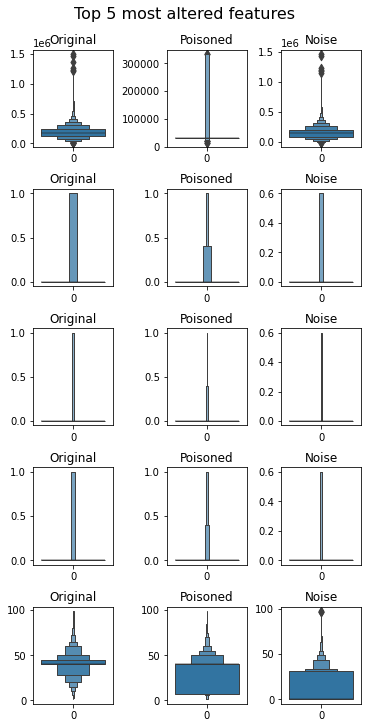

(0.21136542673569847, 0.17620328783093098, 0.25, -0.19955438594599867)

In [7]:
decrease_pmse(synth_data)

# Get Performance Stats without Re-Synthesizing Data

In [8]:
def plot_atk_results(type_one, type_two, name='plot'):
    # make into arrays for easier plotting
    if not isinstance(type_one, type(np.array)): type_one = np.array(type_one)

    _, d = type_one.shape

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(5,10), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=d)

    # plot type one and two
    # pmse_clean, pmse_poisoned, pmse_input, delta
    fig = plt.figure(figsize=(10,5), constrained_layout=True)
    spec = fig.add_gridspec(ncols=d, nrows=2)

    # plot type one
    # pmse_clean, pmse_poisoned, pmse_input, delta
    fontsize=8
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_title('PMSE Clean Orig v Syn', fontsize=fontsize)
    plt.boxplot(type_one[:, 0])

    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_title('PMSE Poisoned Orig v Syn', fontsize=fontsize)
    plt.boxplot(type_one[:, 1])

    ax3 = fig.add_subplot(spec[0, 2])
    ax3.set_title('PMSE % chg', fontsize=fontsize)
    plt.boxplot(type_one[:, 3])

    ax4 = fig.add_subplot(spec[0, 3])
    ax4.set_title('PMSE Clean v Poisoned Orig', fontsize=fontsize)
    plt.boxplot(type_one[:, 2])

    fig.suptitle(name, fontsize=14)
    plt.savefig(name + '.svg')
    plt.show()

# Get Performance Stats with Re-Synthesizing Data

Uncomment to run. Takes a long time.

In [9]:
# num_runs = 10
# type_one_reinit = []
# for i in range(num_runs):
#     print(f'Processing syndata')
#     del synth_data
#     synth_data = getSynthData(processed_data)
#     var = decrease_pmse(synth_data, verbose=False)
#     type_one_reinit.append(var)
# plot_atk_results(type_one_reinit, type_two_reinit, name='Attack Results')